<a href="https://colab.research.google.com/github/rmtu14/ATM-/blob/main/Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

In [71]:
import pandas as pd

# Define data types for columns
dtypes = {
    'ip': 'uint16',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8',
    'click_id': 'uint32'
}

# Read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames= ['ip','app','os','channel','click_time','is_attrubuted']
else:
    train_path = "/content/train_sample.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames= ['ip','app','os','channel','click_time','is_attrubuted']

# Read training data (train_sample.csv)
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes)

# Printing length of training data
print("Length of training data:", len(train_sample))


Length of training data: 100000


In [72]:
print("Memory Usage Information:")
train_sample.info(memory_usage='deep')
train_sample = train_sample.drop("attributed_time", axis=1)
train_sample

Memory Usage Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  uint16
 1   app              100000 non-null  uint16
 2   device           100000 non-null  uint16
 3   os               100000 non-null  uint16
 4   channel          100000 non-null  uint16
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  uint8 
dtypes: object(2), uint16(5), uint8(1)
memory usage: 11.4 MB


,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0
...,...,...,...,...,...,...,...
99995,59347,11,1,19,122,2017-11-09 13:25:41,0
99996,19614,9,1,13,244,2017-11-07 11:25:43,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,0
99998,48740,15,1,12,245,2017-11-08 17:55:21,0


In [73]:
# Calculate space used by the training data in megabytes
space_used_mb = train_sample.memory_usage(deep=True).sum() / (1024 ** 2)

# Display the space used by training data
print("Training dataset uses {:.6f} MB".format(space_used_mb))

Training dataset uses 8.297089 MB


In [74]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [75]:
# Define a function to fetch the number of unique values in each column
def fraction_unique(x):
    return len(x.unique())

# One-liner to use the above function and create a dictionary
number_unique_vals = {col: fraction_unique(train_sample[col]) for col in train_sample.columns}

# Print the dictionary of unique values
print("Number of Unique Values in Each Column:")
print(number_unique_vals)


Number of Unique Values in Each Column:
{'ip': 28470, 'app': 161, 'device': 100, 'os': 130, 'channel': 161, 'click_time': 80350, 'is_attributed': 2}


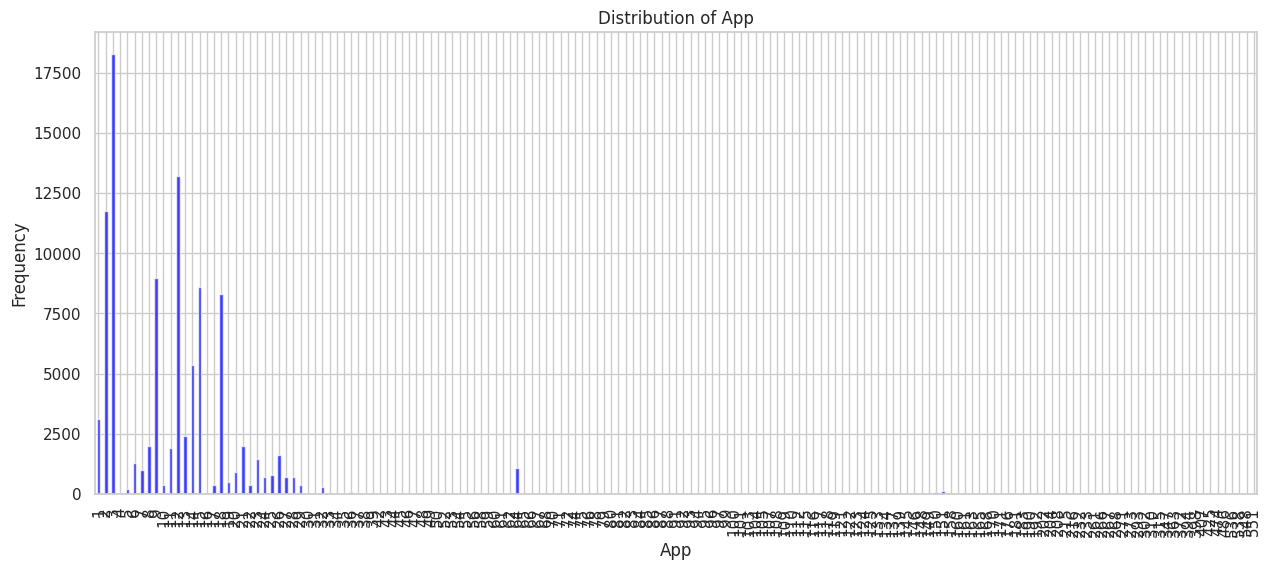

In [76]:
# Plot the distribution of the 'app' column for categorical data
plt.figure(figsize=(15, 6))
train_sample['app'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Distribution of App')
plt.xlabel('App')
plt.ylabel('Frequency')
plt.show()


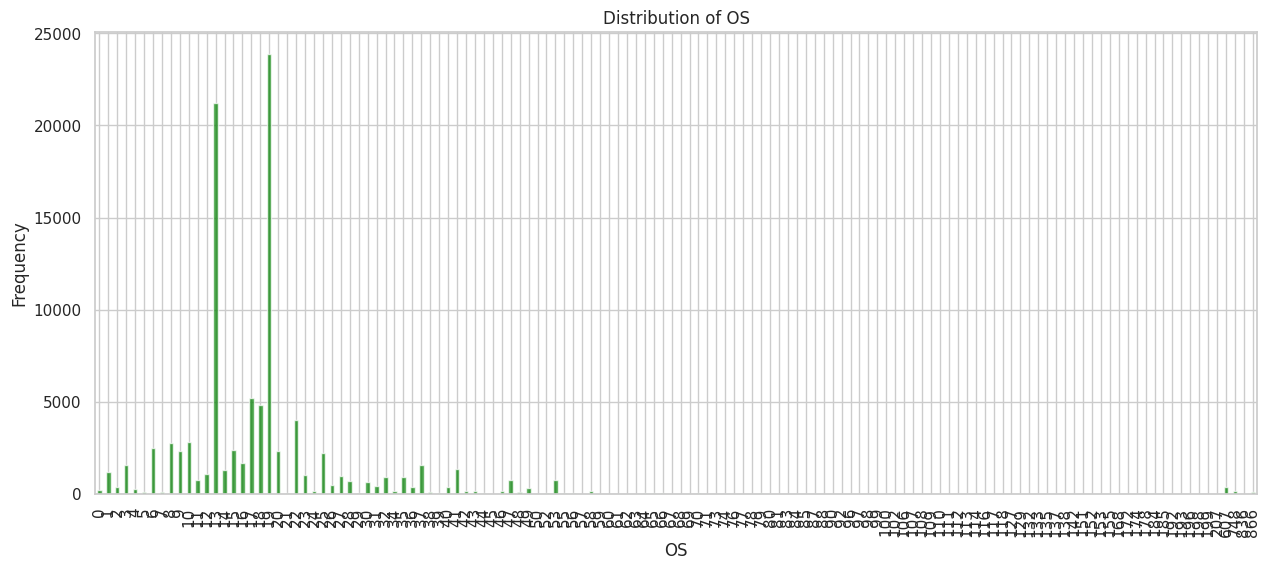

In [77]:
# Plot the distribution of the 'os' column for categorical data
plt.figure(figsize=(15, 6))
train_sample['os'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Distribution of OS')
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.show()


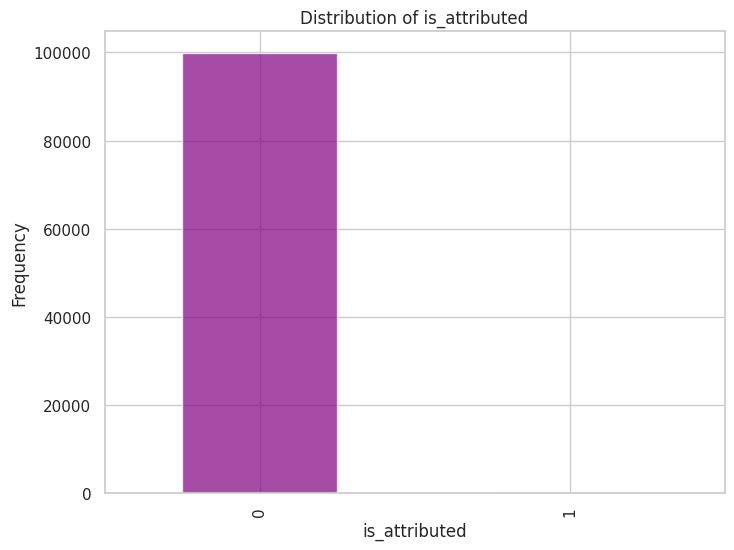

In [78]:
# Plot the distribution of the target variable 'is_attributed'
plt.figure(figsize=(8, 6))
train_sample['is_attributed'].value_counts().sort_index().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Distribution of is_attributed')
plt.xlabel('is_attributed')
plt.ylabel('Frequency')
plt.show()


In [79]:
# Calculate the mean and count of 'is_attributed' grouped by 'app'
app_target = train_sample.groupby('app')['is_attributed'].agg(['mean', 'count'])


# Print the result
app_target


,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [80]:
# Calculate the count of each 'app' and reset index
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')

# Calculate the 80% quantile range
quantile_80 = frequent_apps['count'].quantile(0.8)

# Filter out apps with a count greater than the 80% quantile range
frequent_apps = frequent_apps[frequent_apps['count'] > quantile_80]

# Inner join frequent_apps with train_sample on 'app'
frequent_apps = pd.merge(train_sample, frequent_apps, on='app', how='inner')



frequent_apps.head()

,ip,app,device,os,channel,click_time,is_attributed,count
0,22004,12,1,13,497,2017-11-07 09:30:38,0,13198
1,35888,12,1,19,212,2017-11-07 18:05:24,0,13198
2,2877,12,1,1,178,2017-11-09 09:00:09,0,13198
3,28735,12,1,19,265,2017-11-09 09:55:22,0,13198
4,4618,12,1,40,122,2017-11-07 06:39:04,0,13198


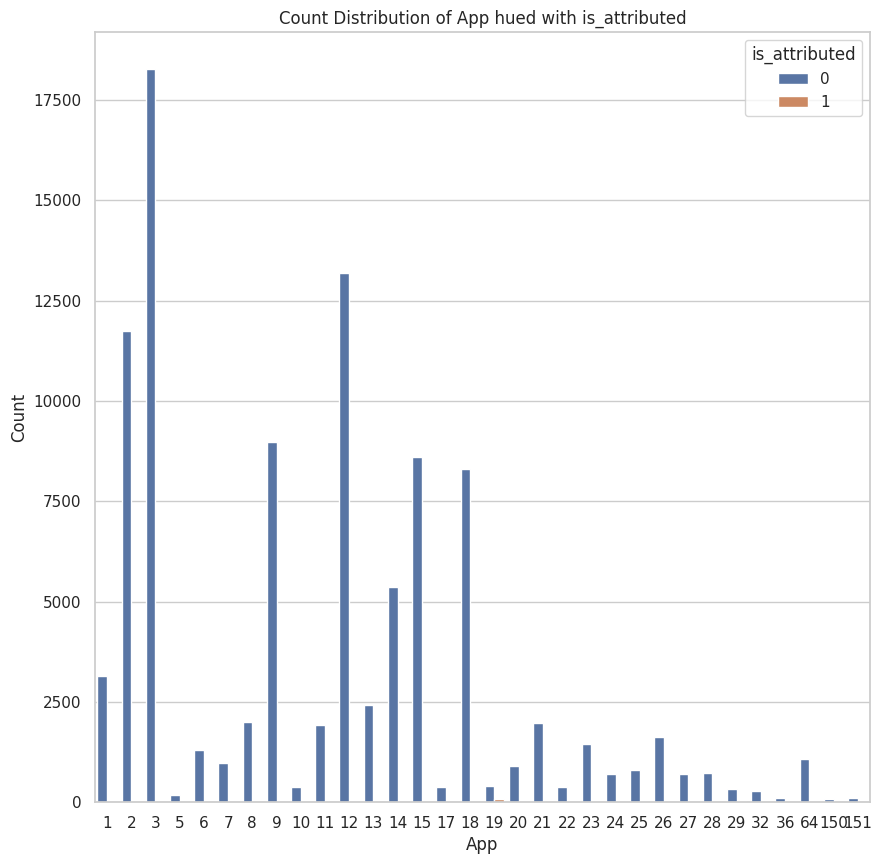

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Plot count distribution of 'app' hued with 'is_attributed'
plt.figure(figsize=(10, 10))
sns.countplot(x='app', hue='is_attributed', data=frequent_apps)
plt.title('Count Distribution of App hued with is_attributed')
plt.xlabel('App')
plt.ylabel('Count')
plt.show()


In [82]:
# Create a function which takes in a df, adds date/time based columns to it, and returns the modified df
def timeFeatures(df):
    # Creating datetime variables using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])

    # Creating day_of_week variables extracting week from the datetime column
    df['day_of_week'] = df['datetime'].dt.dayofweek

    # Creating day_of_year variables extracting day from the datetime column
    df["day_of_year"] = df['datetime'].dt.dayofyear

    # Creating month variables extracting month from the datetime column
    df["month"] = df['datetime'].dt.month

    # Creating hour variables extracting hour from the datetime column
    df["hour"] = df['datetime'].dt.hour

    return df

# Creating new variables using above function with df as train_sample
train_sample = timeFeatures(train_sample)

# Dropping the click_time and datetime variables from train_sample
train_sample = train_sample.drop(['click_time', 'datetime'], axis=1)

# Print train_sample head
print(train_sample.head())


      ip  app  device  os  channel  is_attributed  day_of_week  day_of_year  \
0  22004   12       1  13      497              0            1          311   
1  40024   25       1  17      259              0            1          311   
2  35888   12       1  19      212              0            1          311   
3  29048   13       1  13      477              0            1          311   
4   2877   12       1   1      178              0            3          313   

   month  hour  
0     11     9  
1     11    13  
2     11    18  
3     11     4  
4     11     9  


In [83]:
# Get all int variables in a list
int_vars = [col for col in train_sample.columns if train_sample[col].dtype == 'int64']

# Convert all above variables into uint16 type
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

# Print datatype of all variables in train_sample
print(train_sample.dtypes)


ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object


In [84]:
# Create a column 'ip_count' using the number of clicks by count of IP address
train_sample['ip_count'] = train_sample.groupby('ip')['ip'].transform('count')

# Print the head of ip_count
train_sample[['ip', 'ip_count']].head()


,ip,ip_count
0,22004,8
1,40024,149
2,35888,2
3,29048,3
4,2877,4


In [85]:
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')

    # ip_day_hour
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')

    # ip_hour_channel
    ip_hour_channel = df.groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')

    # ip_hour_os
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).size().reset_index(name='ip_hour_os').astype('uint16')

    # ip_hour_app
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).size().reset_index(name='ip_hour_app').astype('uint16')

    # ip_hour_device
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).size().reset_index(name='ip_hour_device').astype('uint16')

    # Merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')

    # Delete intermediate DataFrames
    del ip_count, ip_day_hour, ip_hour_channel, ip_hour_os, ip_hour_app, ip_hour_device

    return df

# Use the grouped_features() function with train_sample as a parameter to create your new train_sample data
train_sample = grouped_features(train_sample)

# Print the head of train_sample
train_sample.head()


,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count_x,ip_count_y,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,4,1,1,1,1,1


In [86]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named train_sample with the relevant columns
# Replace 'your_target_column' with the actual name of your target column
X = train_sample.drop('is_attributed', axis=1)  # Exclude unnecessary columns
y = train_sample[['is_attributed']]

# Split data into train and test/validation sets with test_size as 20% and random state as 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Print shape of X_train, y_train, X_test, and y_test
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (80000, 16)
y_train shape: (80000, 1)
X_test shape: (20000, 16)
y_test shape: (20000, 1)


In [87]:
# Assuming you have already split your data into X_train, y_train, X_test, and y_test

# Calculate average download rate in train data
y_train.mean()


# Calculate average download rate in test data




is_attributed    0.002275
dtype: float64

In [88]:
y_test.mean()

is_attributed    0.00225
dtype: float64

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Instantiate DecisionTreeClassifier with max_depth as 2 and random state as 1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate AdaBoostClassifier
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=100,
    learning_rate=1.5,
    algorithm='SAMME',
    random_state=1
)





In [90]:
adaboost_model_1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.5, n_estimators=100, random_state=1)

In [91]:
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.57980968, 0.42019032],
       [0.57026291, 0.42973709],
       [0.57658083, 0.42341917],
       [0.52546509, 0.47453491],
       [0.53487777, 0.46512223],
       [0.56119995, 0.43880005],
       [0.55475869, 0.44524131],
       [0.56821366, 0.43178634],
       [0.5451816 , 0.4548184 ],
       [0.52738103, 0.47261897]])

In [92]:
from sklearn.metrics import roc_auc_score

# Reshape predictions if needed
predictions = predictions.reshape(-1, 2)

# Calculate AUC score
auc_score = roc_auc_score(y_test, predictions[:, 1])

# Print the AUC score
print("AUC Score:", auc_score)


AUC Score: 0.9504819176480415


In [97]:
param_grid = {
    'base_estimator__max_depth': [2, 5],
    'n_estimators': [200, 400, 600]
}

tree = DecisionTreeClassifier(random_state=1)

ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm='SAMME'
)

folds = 3

grid_search_ABC = GridSearchCV(
    ABC,
    cv=folds,
    param_grid=param_grid,
    scoring='roc_auc',
    return_train_score=True,
    verbose=1
)

grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(random_state=1),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [98]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,13.981080,0.140637,0.380528,0.002734,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,6.111043e-04
1,27.793183,0.346860,1.097358,0.240403,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,6.179779e-04
2,41.941646,0.287870,1.104588,0.007861,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,2.530744e-04
3,30.627224,0.606898,0.560209,0.137189,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.904276,0.939726,0.942123,0.928709,0.017304,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,61.634346,0.396110,1.129896,0.256641,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.890631,0.939590,0.945133,0.925118,0.024491,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,91.528150,0.312633,1.588363,0.330948,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.882505,0.925601,0.937908,0.915338,0.023754,6,1.000000,1.000000,1.000000,1.000000,6.409876e-17


In [110]:

tree = DecisionTreeClassifier(max_depth=2,random_state=1)
ABC = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators = 200,
    learning_rate=0.6,
    algorithm='SAMME', random_state = 1
)
ABC.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.6, n_estimators=200, random_state=1)

In [111]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.61058431, 0.38941569],
       [0.60742586, 0.39257414],
       [0.63265753, 0.36734247],
       [0.58758342, 0.41241658],
       [0.57045678, 0.42954322],
       [0.61162484, 0.38837516],
       [0.59403993, 0.40596007],
       [0.60805124, 0.39194876],
       [0.60362848, 0.39637152],
       [0.57654304, 0.42345696]])

In [101]:
# Import necessary libraries
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# Instantiate LGBMClassifier with default hyperparameters and random_state=1
LGB = LGBMClassifier(random_state=1)

# Fit model on training data
LGB.fit(X_train, y_train)

# Use predict_proba since we need probabilities to compute auc
y_pred_proba = LGB.predict_proba(X_test)

# Print top 10 y_pred_proba results
print(y_pred_proba[:10])

# Evaluate predictions using roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'ROC AUC Score: {roc_auc}')


[LightGBM] [Info] Number of positive: 182, number of negative: 79818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002275 -> initscore=-6.083498
[LightGBM] [Info] Start training from score -6.083498
[[9.99997609e-01 2.39140823e-06]
 [9.99985124e-01 1.48759511e-05]
 [9.99998668e-01 1.33213465e-06]
 [9.99985600e-01 1.43999851e-05]
 [9.99935485e-01 6.45154560e-05]
 [9.99994911e-01 5.08854217e-06]
 [9.99995125e-01 4.87501640e-06]
 [1.00000000e+00 4.45827227e-12]
 [1.00000000e+00 0.00000000e+00]
 [9.99965187e-01 3.48131849e-05]]
ROC AUC Score: 0.8462212199671483
